# NYPD Allegations

# Summary of Findings


### Introduction
  Our prediction problem is to classify whether each alleged incident is confirmed (substantiated or exonerated) by board or not (unsubstantiated) based on selected columns. It is a classification problem. We picked our target variable to be the board disposition because we think it is the most important column and it is the outcome of the entire dataframe. Also, we think that a lot of other features probably contribute to help predict this final result. We decided to use F1 score as our evaluation metric because it is a metric taking both the true positive rate and precision into consideration. If the true positive rate is too low, it would be unfair for the complainant and if the precision is too low, it would also be unfair for the officer.

### Baseline Model
In our baseline model, we used a Logistic Regression Model with 15 features, 2 of which are quantitative, 4 are ordinal, and 9 are nominal. We dropped some columns that are deemed not contributing to the final outcome or not obtainable at the time of prediction, some of which include "unique_mos_id", "rank_abbrev_now", "rank_now", and "complaint_id". We think "rank_abbrev_now", "rank_now", "command_now" columns will not be available at the time of prediction, and columns like "outcome_description", "unique_mos_id", "first_name", "last_name", "complaint_id", "shield_no" are not very helpful. "rank_incident" already has a similar column "rank_abbrev_incident". The "precinct" column is also dropped because it is not directly related to the allegation outcome, and it is recorded as numbers in the original dataframe, and easily treated by the model as quantitative even though it is nominal. The mean F1 score from the baseline model is about 0.71-0.73 depending on the train-test split, which is not bad but can definitely be improved, since the best score for F1 score is 1 and the worst is 0. We have not done much feature engineering on the original table, thus the F1 score still has the potential to be higher.

### Final Model
Firstly, we changed our classifier from Logistic Regression to K-Neighbors Classifier and Random Forest Classifier to see if there are any improvements. After checking the mean F1 score of these two new classifiers and comparing them with the mean F1 score of the base line model (Logistic Regression), we decided to use Random Forest Classifier, which has the highest F1 score, as our final classifier.
Secondly, we added two new features to the data set. The first one is whether the officer and the complainant have the same ethnicity. The reason why we include this feature is that we think the board might take the racial problem into consideration when giving the final desposition. The other feature is the duration of the case calculated by the year/month received and year/month closed. We think that for non-confirmed case (Unsubstantiated), the board might take longer time to investigate to make this despotion. The EDA on these two features also shows that there is a difference in mean between the two categories.
The final effort on choosing the final model is that we use Grid Search Cross-validation to decide the best max_depth for the Random Forest Classifer. 

### Fairness Evaluation
For the fairness evaluation, we want to evaluate the fairness based on the ethnicity of the officers. For simplicity, we binarize the ethnicity into White and Non-white. The prediction and the evaluation is done with only the test set.
When doing this fairness evaluation, we would use precision as the metric. The reason is that if the precision (proportion of correct positive identification) is too low for one ethnicity group, there would be many false positive cases and significantly affects the reputation of the officer. 

For the permutation test: 
- Null Hypothesis: the precision socre for white officers and non-white officers are the same
- Alternative Hypothesis: the precision socre for white officers and non-white officers are not the same

Our p-value from the permutation test is 0.53. Since the p-value is larger than 0.05, we fail to reject the null hypothesis. The result of this fairness evaluation is that our model is fair for both the white officers and non-white officers in terms of precision score. We also used confusion matrix to confirm our result.

<hr>

# Code

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

In [2]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


In [3]:
nypd = pd.read_csv('allegations_202007271729.csv')
nypd.head()

,unique_mos_id,first_name,last_name,command_now,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,...,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,fado_type,allegation,precinct,contact_reason,outcome_description,board_disposition
0,10004,Jonathan,Ruiz,078 PCT,8409,42835,7,2019,5,2020,...,32,Black,Female,38.0,Abuse of Authority,Failure to provide RTKA card,78.0,Report-domestic dispute,No arrest made or summons issued,Substantiated (Command Lvl Instructions)
1,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,24,Black,Male,26.0,Discourtesy,Action,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)
2,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,24,Black,Male,26.0,Offensive Language,Race,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)
3,10007,John,Sears,078 PCT,5952,26146,7,2012,9,2013,...,25,Black,Male,45.0,Abuse of Authority,Question,67.0,PD suspected C/V of violation/crime - street,No arrest made or summons issued,Substantiated (Charges)
4,10009,Noemi,Sierra,078 PCT,24058,40253,8,2018,2,2019,...,39,NaN,NaN,16.0,Force,Physical force,67.0,Report-dispute,Arrest - other violation/crime,Substantiated (Command Discipline A)


<hr>

## Baseline Model

In [4]:
# Step1: Drop Columns
police = nypd.drop(columns = ['outcome_description', 
                         'unique_mos_id', 'rank_abbrev_now', 
                         'rank_now', 'first_name', 'last_name', 
                         'command_now', 'shield_no', 'complaint_id',
                        'rank_incident', 'precinct'])
# Step 2: Add needed column, 
# fill nan instead of droping the row since the missness might be a good predictor
police['status'] = np.where(police["board_disposition"] == "Exonerated", 1, 
                            np.where(police["board_disposition"] == "Unsubstantiated", 0, 
                         1))
police['complainant_ethnicity'] = police['complainant_ethnicity'].fillna('Unknown')
police = police.drop(columns = 'board_disposition')
police['complainant_ethnicity'] = police['complainant_ethnicity'].fillna('Unknown')
police['complainant_gender'] = police['complainant_gender'].fillna('Not described')
police['complainant_age_incident'] = police['complainant_age_incident'].fillna('-1')
police['complainant_age_incident'] = police['complainant_age_incident'].apply(lambda x: 
                                                        int(x) if int(x) >= 6 else -1)
police = police.dropna()
police.head()

,month_received,year_received,month_closed,year_closed,command_at_incident,rank_abbrev_incident,mos_ethnicity,mos_gender,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,fado_type,allegation,contact_reason,status
0,7,2019,5,2020,078 PCT,POM,Hispanic,M,32,Black,Female,38,Abuse of Authority,Failure to provide RTKA card,Report-domestic dispute,1
1,11,2011,8,2012,PBBS,POM,White,M,24,Black,Male,26,Discourtesy,Action,Moving violation,1
2,11,2011,8,2012,PBBS,POM,White,M,24,Black,Male,26,Offensive Language,Race,Moving violation,1
3,7,2012,9,2013,PBBS,POM,White,M,25,Black,Male,45,Abuse of Authority,Question,PD suspected C/V of violation/crime - street,1
4,8,2018,2,2019,078 PCT,POF,Hispanic,F,39,Unknown,Not described,16,Force,Physical force,Report-dispute,1


In [5]:
# ignore the Convergence warning when using logistic regression
from warnings import filterwarnings
filterwarnings('ignore')

In [7]:
#Step 3: Pipeline, and build baseline model with Logistic Regression
preproc = ColumnTransformer(
    transformers=[
        ('oneHot', OneHotEncoder(handle_unknown = 'ignore'), 
         ['mos_ethnicity', 'mos_gender',                       
          'complainant_ethnicity', 
          'complainant_gender', 
          'fado_type', 
        'contact_reason','rank_abbrev_incident', 
        'command_at_incident', 'allegation'])], 
    remainder = 'passthrough')
pl = Pipeline([('one_hot',preproc), ('logistic', 
                                     LogisticRegression(penalty = 'none'))
              ])
test=[]
# Check out the mean F1 score from the baseline model, 
# as well as see fluctuation in 5 trials
for _ in range(5):
    X_train, X_test, y_train, y_test = train_test_split(
            police.drop(columns=['status']),
            police['status'], 
            test_size=0.25)
    pl.fit(X_train, y_train)
    test_result = pl.predict(X_test)
    test_accuracy = f1_score(y_test, test_result)
    test.append(test_accuracy)
    
print(np.mean(test))
print(test)

0.7231096571036105
[0.7193444541995901, 0.7268658168726281, 0.7258097792448938, 0.7214797598295566, 0.722048475371384]


<hr>

## Final Model

### Choose the best classifer

In [8]:
# Try other classifiers
# KNN
preproc = ColumnTransformer(
    transformers=[
        ('oneHot', OneHotEncoder(handle_unknown = 'ignore'), 
         ['mos_ethnicity', 
         'mos_gender', 
        'complainant_ethnicity', 
        'complainant_gender', 
        'fado_type', 
        'contact_reason',
        'rank_abbrev_incident', 
        'command_at_incident', 
        'allegation'])], 
    remainder = 'passthrough')
pl = Pipeline([('one_hot',preproc), ('KNN', KNeighborsClassifier())
              ])
test=[]
# Check out the mean F1 score from KNN model and fluctuation in 5 trials, 
# compare with baseline
for _ in range(5):
    X_train, X_test, y_train, y_test = train_test_split(
            police.drop(columns=['status']),
            police['status'], 
            test_size=0.25)
    pl.fit(X_train, y_train)
    test_result = pl.predict(X_test)
    test_accuracy = f1_score(y_test, test_result)
    test.append(test_accuracy)
    
print(np.mean(test))
print(test)

0.6535076344689108
[0.6558657934045731, 0.646429803380476, 0.6585504608032767, 0.6622425629290618, 0.6444495518271662]


The mean F1 score using KNN is significantly low than the baseline model, so we go on and seek for other options.

In [9]:
# Try other classifiers
# Random Forest
preproc = ColumnTransformer(
    transformers=[
        ('oneHot', OneHotEncoder(handle_unknown = 'ignore'), ['mos_ethnicity', 
                                                              'mos_gender', 
                                                              'complainant_ethnicity', 
                                                              'complainant_gender', 
                                    
                                                              'fado_type', 
                                                              'contact_reason',
                                                              'rank_abbrev_incident', 
                                                              'command_at_incident',
                                                              'allegation'])], 
    remainder = 'passthrough')
pl = Pipeline([('one_hot',preproc), ('RFC', RandomForestClassifier())
              ])
test=[]
# Check out the mean F1 score from Random FOrest Classifier and its fluctuation in 5 trials,
# and compare with KNN and baseline
for _ in range(5):
    X_train, X_test, y_train, y_test = train_test_split(
            police.drop(columns=['status']),
            police['status'], 
            test_size=0.25)
    pl.fit(X_train, y_train)
    test_result = pl.predict(X_test)
    test_accuracy = f1_score(y_test, test_result)
    test.append(test_accuracy)
    
print(np.mean(test))
print(test)

0.7639003261384386
[0.7637786472889883, 0.7686005314437556, 0.7587294435683711, 0.7619152935972576, 0.7664777147938201]


We see a significant improvement using the Random Forest Classifier, so we'll keep it as the final classifier.

### Add new features

In [10]:
# Add a column of whether officer and complainant have the same ethnicity
police_new = police.copy()
police_new['ethnicity_difference'] = (police_new['complainant_ethnicity'] 
                                      == police_new['mos_ethnicity']).astype(int)

# Calculate duration using month recceived and month closed, using pandas datetime 
police_new = police_new.rename(columns={'year_received':'year', "month_received": 'month'})
police_new['day'] = [1]*police_new.shape[0]
police_new['time_received'] = pd.to_datetime(police_new[['year','month', 'day']])
police_new = police_new.rename(columns={'year':'year_received', "month": 'month_received'})
police_new = police_new.rename(columns={'year_closed':'year', "month_closed": 'month'})
police_new['time_closed'] = pd.to_datetime(police_new[['year','month', 'day']])
police_new['duration'] = (police_new['time_closed'] - police_new['time_received']).astype(str)
police_new['duration'] = police_new['duration'].str[:-4].astype(int)
police_new = police_new.rename(columns={'year':'year_closed', "month": 'month_closed'})
police_new = police_new.drop(columns={'day', 'time_received', 'time_closed'})

In [11]:
# Explore the average ethnicity difference across each final status(confirmed or not)
police_new.groupby('status').mean()['ethnicity_difference']

status
0    0.227974
1    0.199206
Name: ethnicity_difference, dtype: float64

In [12]:
# Explore the average duration of allegations across each final status(confirmed or not)
police_new.groupby('status').mean()['duration']

status
0    317.237197
1    301.349224
Name: duration, dtype: float64

In [13]:
police_new.head()

,month_received,year_received,month_closed,year_closed,command_at_incident,rank_abbrev_incident,mos_ethnicity,mos_gender,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,fado_type,allegation,contact_reason,status,ethnicity_difference,duration
0,7,2019,5,2020,078 PCT,POM,Hispanic,M,32,Black,Female,38,Abuse of Authority,Failure to provide RTKA card,Report-domestic dispute,1,0,305
1,11,2011,8,2012,PBBS,POM,White,M,24,Black,Male,26,Discourtesy,Action,Moving violation,1,0,274
2,11,2011,8,2012,PBBS,POM,White,M,24,Black,Male,26,Offensive Language,Race,Moving violation,1,0,274
3,7,2012,9,2013,PBBS,POM,White,M,25,Black,Male,45,Abuse of Authority,Question,PD suspected C/V of violation/crime - street,1,0,427
4,8,2018,2,2019,078 PCT,POF,Hispanic,F,39,Unknown,Not described,16,Force,Physical force,Report-dispute,1,0,184


In [14]:
# Try random forest with new features (with default parameters)
preproc = ColumnTransformer(
    transformers=[
        ('oneHot', OneHotEncoder(handle_unknown = 'ignore'), 
         ['mos_ethnicity', 'mos_gender', 'complainant_ethnicity', 
          'complainant_gender', 
          'fado_type', 'contact_reason','rank_abbrev_incident',
          'command_at_incident', 'allegation'])], 
    remainder = 'passthrough')
pl = Pipeline([('one_hot',preproc), ('RFC', RandomForestClassifier())
              ])
test=[]
# Check out the mean F1 score, also check out the fluctuations across 5 trials
for _ in range(5):
    X_train, X_test, y_train, y_test = train_test_split(
            police_new.drop(columns=['status']),
            police_new['status'], 
            test_size=0.25)
    pl.fit(X_train, y_train)
    test_result = pl.predict(X_test)
    test_accuracy = f1_score(y_test, test_result)
    test.append(test_accuracy)
    
print(np.mean(test))
print(test)


0.7659698736672652
[0.7630315883469138, 0.7708403644954438, 0.7633859142412798, 0.7610224355396809, 0.7715690657130084]


The feature-engineered model is indeed better than the original Random Forest Model, but there are still ways to improve.

### Find the best parameter (max_depth)

In [15]:
# modify the parameters of the random forest to seek for the best prameter
parameters = {'RFC__max_depth':[150, 200, 250, 300, None]}
clf = GridSearchCV(pl, parameters, cv=5, scoring = 'f1')
clf.fit(police_new.drop(columns=['status']), police_new['status'])
print("Best parameter (CV score=%0.3f):" % clf.best_score_)
print(clf.best_params_)

Best parameter (CV score=0.745):
{'RFC__max_depth': 250}


In [16]:
# modify the parameters of the random forest to seek for the best prameter
parameters = {'RFC__max_depth':[220, 250, 270]}
clf = GridSearchCV(pl, parameters, cv=5, scoring = 'f1')
clf.fit(police_new.drop(columns=['status']), police_new['status'])
print("Best parameter (CV score=%0.3f):" % clf.best_score_)
print(clf.best_params_)

Best parameter (CV score=0.746):
{'RFC__max_depth': 220}


In [17]:
# modify the parameters of the random forest to seek for the best prameter
parameters = {'RFC__max_depth':[210, 220, 230]}
clf = GridSearchCV(pl, parameters, cv=5, scoring = 'f1')
clf.fit(police_new.drop(columns=['status']), police_new['status'])
print("Best parameter (CV score=%0.3f):" % clf.best_score_)
print(clf.best_params_)

Best parameter (CV score=0.745):
{'RFC__max_depth': 220}


After gradually narrow down the range for the max-depth of the classifier using Grid Search Cross-validation, we found that the best model and our final model should be the Random Forest classifer with roughly 220 as the max-depth.

### Get the best model

In [19]:
preproc = ColumnTransformer(
    transformers=[
        ('oneHot', OneHotEncoder(handle_unknown = 'ignore'), 
         ['mos_ethnicity', 'mos_gender', 'complainant_ethnicity',
          'complainant_gender', 
          'fado_type', 'contact_reason',
          'rank_abbrev_incident', 
          'command_at_incident', 'allegation'])], 
    remainder = 'passthrough')
pl = Pipeline([('one_hot',preproc), ('RFC', RandomForestClassifier(max_depth=220))
              ])

test=[]
for _ in range(5):
    X_train, X_test, y_train, y_test = train_test_split(
            police_new.drop(columns=['status']),
            police_new['status'], 
            test_size=0.25)
    pl.fit(X_train, y_train)
    test_result = pl.predict(X_test)
    test_accuracy = f1_score(y_test, test_result)
    test.append(test_accuracy)
    
print(np.mean(test))
print(test)


0.7644372952543749
[0.7648826082118616, 0.7649933362949799, 0.7650931815645575, 0.7646793134598013, 0.7625380367406739]


One thing to notice is that the mean F1 socre for our best model is not much different to the mean F1 score for the model with default setting (max_depth = 'none'). However, after checking the all the scores, it's clear that the flucturation for the default model is much larger. This is because we do not give a ramdom_state for the model as well as the train_test split, and the overfitted default model will be affected more by this randomness. Thus, the improved model is overall better than the default one.

<hr>

## Fairness Evaluation

Use a permutation test to check whether or not the difference of precision score on white and non-white officers is due to chance.

In [21]:
# Split train and test dataset since we still 
# want to check the fairness on the "unseen" data
# Train using the best final model above
X_train, X_test, y_train, y_test = train_test_split(
        police_new.drop(columns=['status']),
        police_new['status'], 
        test_size=0.25)

# Fit the model with training data and predict using test data
pl.fit(X_train, y_train)

# Combine test data and prediction from the model
with_prediction = pd.concat([X_test, y_test], axis=1).assign(
    prediction = pl.predict(X_test))

# Binarize the ethnicity and find the observed absolute 
# difference between precision scores across 
# white VS non-white officers
with_prediction['mos_ethnicity'] = np.where(with_prediction['mos_ethnicity'] == 
                                            'White', 'White', 'Non-white')
obs = with_prediction.groupby('mos_ethnicity').apply(lambda x: 
                            precision_score(x.status, 
                                            x.prediction)).diff().abs().iloc[-1]
print(obs)

# Permutation test: permute the ethnicity column and 
# randomly assign to each outcome, then record
# the absolute difference between precision scores 
# between white VS non-white officers since the 
# alternative hypothesis is two-tailed
diffs = []
trial = 100
for _ in range(trial):
    permuted = with_prediction.assign(mos_ethnicity = 
                    np.random.permutation(with_prediction["mos_ethnicity"].values))
    diff = permuted.groupby('mos_ethnicity').apply(lambda x: 
                    precision_score(x.status, x.prediction)).diff().abs().iloc[-1]
    diffs.append(diff)
    
# Calculate P values, the proportion of permutation results at least as extreme as 
# the observed difference
print(np.mean(diffs >= obs))

0.00819517299871364
0.53


The p-value is significantly larger than 0.05, thus we fail to reject the null hypothesis

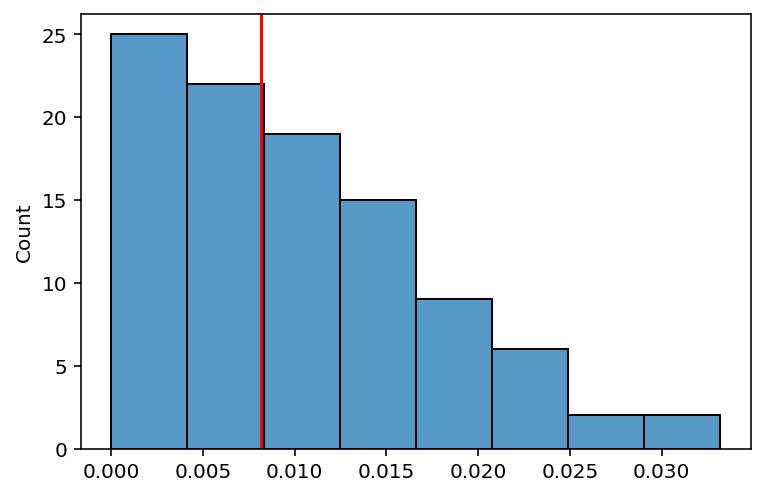

In [22]:
# Histogram for the permutated absolute value of precision scores difference 
# and the observed difference, the observed value is not very extreme
sns.histplot(data = diffs).axvline(x=obs, color='r')

 Check out the confusion matrix for the predictions.
 The upper-right corner is the number of cases that are false positive.

<AxesSubplot:>

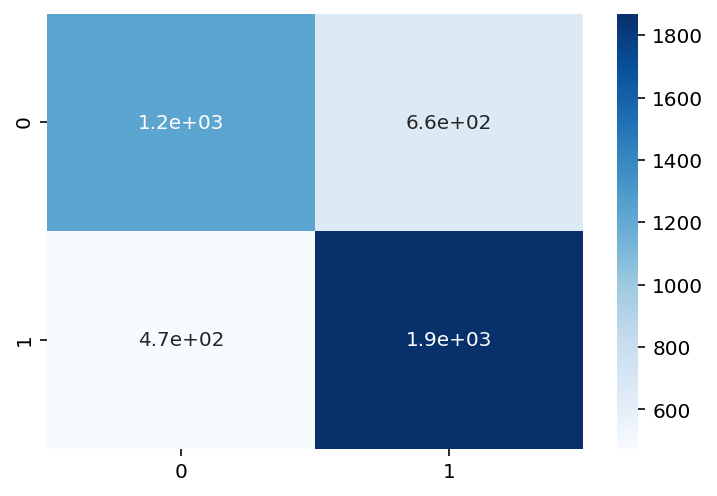

In [23]:
# Confusion matrix for white officers
white_of = with_prediction[with_prediction['mos_ethnicity'] == 'White']
w_prediction = confusion_matrix(white_of.status, white_of.prediction)
sns.heatmap(w_prediction, annot=True, cmap='Blues')

<AxesSubplot:>

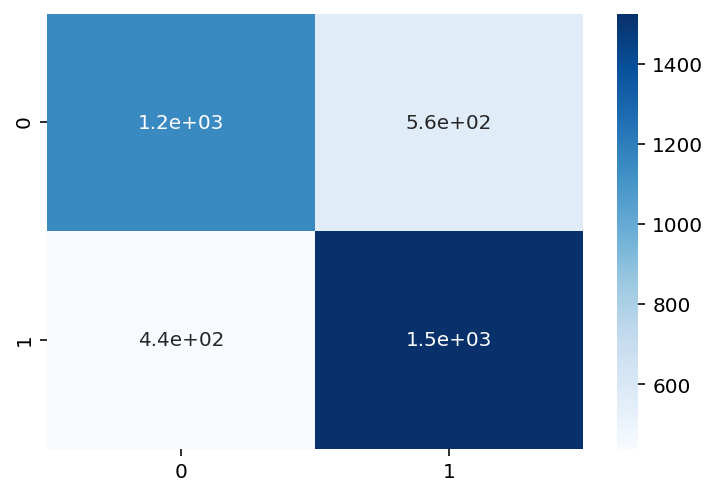

In [24]:
# Confusion matrix for non-white officers
n_white_of = with_prediction[with_prediction['mos_ethnicity'] != 'White']
n_w_prediction = confusion_matrix(n_white_of.status, n_white_of.prediction)
n_w_prediction
sns.heatmap(n_w_prediction, annot=True, cmap='Blues')

The matrix for white and non-white officers indeed have similar false positive rate.

<hr>

# Finish!